In [1]:
import wfdb
import os

data_path = 'mitbih'  # replace with your actual path
record_ids = []

# Get all .dat files and extract record names (without extension)
for file in os.listdir(data_path):
    if file.endswith('.dat'):
        record_ids.append(file.split('.')[0])

record_ids = sorted(list(set(record_ids)))  # Remove duplicates and sort

print(f"Found {len(record_ids)} records:", record_ids)


Found 48 records: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [2]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.2 MB/s eta 0:00:005.9 MB/s eta 0:00:01


In [2]:
import numpy as np

X = []
y = []

for rec_id in record_ids:
    try:
        record = wfdb.rdrecord(os.path.join(data_path, rec_id))
        annotation = wfdb.rdann(os.path.join(data_path, rec_id), 'atr')

        signal = record.p_signal[:, 0]  # use Lead I
        ann_samples = annotation.sample
        ann_symbols = annotation.symbol

        for i, sample in enumerate(ann_samples):
            if sample - 90 < 0 or sample + 90 > len(signal):
                continue
            beat_segment = signal[sample - 90: sample + 90]

            # Binary labeling: 0 = normal, 1 = abnormal
            label = 0 if ann_symbols[i] == 'N' else 1

            X.append(beat_segment)
            y.append(label)

    except Exception as e:
        print(f"Skipping record {rec_id}: {e}")

X = np.array(X).reshape(-1, 180, 1)
y = np.array(y)


In [3]:
X

array([[[-0.305],
        [-0.31 ],
        [-0.3  ],
        ...,
        [-0.43 ],
        [-0.42 ],
        [-0.43 ]],

       [[-0.33 ],
        [-0.345],
        [-0.345],
        ...,
        [-0.42 ],
        [-0.425],
        [-0.415]],

       [[-0.375],
        [-0.385],
        [-0.355],
        ...,
        [-0.365],
        [-0.385],
        [-0.38 ]],

       ...,

       [[-0.275],
        [-0.27 ],
        [-0.27 ],
        ...,
        [-0.26 ],
        [-0.265],
        [-0.285]],

       [[-0.235],
        [-0.225],
        [-0.205],
        ...,
        [-0.215],
        [-0.225],
        [-0.225]],

       [[-0.185],
        [-0.19 ],
        [-0.185],
        ...,
        [-0.285],
        [-0.29 ],
        [-0.285]]])

In [4]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
print("X shape:", X.shape)
print("y shape:", y.shape)

print("Example label:", y[0])
print("Example signal segment:", X[0].flatten()[:10])  # first 10 points


X shape: (112579, 180, 1)
y shape: (112579,)
Example label: 0
Example signal segment: [-0.305 -0.31  -0.3   -0.305 -0.29  -0.3   -0.3   -0.305 -0.305 -0.29 ]


In [6]:
import pandas as pd

# Flatten 180 points into columns
df = pd.DataFrame(X.reshape(X.shape[0], 180))
df['label'] = y

print(df.head())


       0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.305 -0.310 -0.300 -0.305 -0.290 -0.300 -0.300 -0.305 -0.305 -0.290  ...   
1 -0.330 -0.345 -0.345 -0.355 -0.350 -0.340 -0.330 -0.340 -0.340 -0.340  ...   
2 -0.375 -0.385 -0.355 -0.360 -0.355 -0.360 -0.360 -0.370 -0.360 -0.345  ...   
3 -0.345 -0.345 -0.350 -0.355 -0.345 -0.330 -0.330 -0.335 -0.335 -0.340  ...   
4 -0.340 -0.340 -0.340 -0.325 -0.325 -0.325 -0.345 -0.350 -0.340 -0.330  ...   

     171    172    173   174    175    176    177    178    179  label  
0 -0.410 -0.415 -0.425 -0.42 -0.435 -0.430 -0.430 -0.420 -0.430      0  
1 -0.415 -0.405 -0.405 -0.41 -0.415 -0.420 -0.420 -0.425 -0.415      0  
2 -0.370 -0.375 -0.385 -0.39 -0.390 -0.375 -0.365 -0.385 -0.380      0  
3 -0.425 -0.425 -0.425 -0.42 -0.425 -0.450 -0.445 -0.450 -0.435      0  
4 -0.395 -0.395 -0.405 -0.41 -0.425 -0.425 -0.410 -0.410 -0.420      0  

[5 rows x 181 columns]


In [7]:
import numpy as np

print("Total beats:", len(y))
print("Normal (0):", np.sum(y == 0))
print("Abnormal (1):", np.sum(y == 1))


Total beats: 112579
Normal (0): 75033
Abnormal (1): 37546


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

2025-05-07 16:56:56.086095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 16:56:56.112397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 16:56:56.120531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 16:56:56.216023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/sayantan/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2025-05-07 17:00:16.214160: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9228 - loss: 0.2253 - val_accuracy: 0.9716 - val_loss: 0.0950
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9715 - loss: 0.0948 - val_accuracy: 0.9745 - val_loss: 0.0809
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.9842 - val_loss: 0.0542
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9802 - loss: 0.0671 - val_accuracy: 0.9829 - val_loss: 0.0608
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9820 - loss: 0.0629 - val_accuracy: 0.9838 - val_loss: 0.0549
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9833 - loss: 0.0528 - val_accuracy: 0.9823 - val_loss: 0.0628
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9840 - loss: 0.0512 - val_accuracy: 0.9858 - val_loss: 0.0494
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9846 - loss: 0.0473 - val_accurac

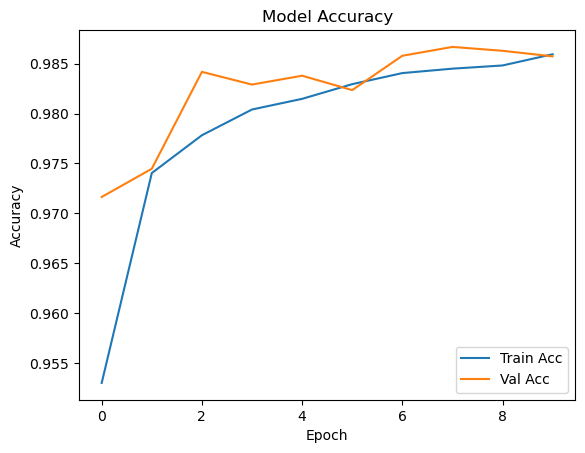

In [11]:

# Split data
X = np.array(X)  # Ensure it's a NumPy array
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(180, 1)),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mat)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
# Save model
model.save("ecg_cnn_model.h5")


In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("ecg_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpdg6ryw10/assets


INFO:tensorflow:Assets written to: /tmp/tmpdg6ryw10/assets


Saved artifact at '/tmp/tmpdg6ryw10'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133276275469552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275704048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275706160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275705280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275466560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275705456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275703872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275707568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275707920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275709504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133276275708096: Te

W0000 00:00:1746617863.718478   28727 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1746617863.718504   28727 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-05-07 17:07:43.719291: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdg6ryw10
2025-05-07 17:07:43.720103: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-07 17:07:43.720113: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdg6ryw10
2025-05-07 17:07:43.725807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-05-07 17:07:43.727573: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-07 17:07:43.766351: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdg6ryw10
2025-05-07 17:07:43.778745: I tensorflow/cc/saved_model/loader.cc

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.tensorflow
import os

mlflow.set_tracking_uri("http://127.0.0.1:5002/")
# Enable MLflow auto-logging
mlflow.tensorflow.autolog()

# Data preparation
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model parameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

with mlflow.start_run():
    # Model
    model = Sequential([
        Conv1D(32, 5, activation='relu', input_shape=(180, 1)),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Log hyperparameters manually
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_accuracy", acc)
    print(f"\nTest Accuracy: {acc:.4f}")

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write(classification_report(y_test, y_pred))
    mlflow.log_artifact(report_path)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_path = "confusion_matrix.txt"
    with open(conf_mat_path, "w") as f:
        f.write(np.array2string(conf_mat))
    mlflow.log_artifact(conf_mat_path)

    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("accuracy_plot.png")
    mlflow.log_artifact("accuracy_plot.png")
    plt.close()


2025-06-02 11:23:30.511437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 11:23:30.543392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 11:23:30.555346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 11:23:30.673272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/sayantan/anaconda3/envs/ml/li

Epoch 1/10
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9220 - loss: 0.2254 

563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9221 - loss: 0.2251 - val_accuracy: 0.9494 - val_loss: 0.1579
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9721 - loss: 0.0910 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9721 - loss: 0.0910 - val_accuracy: 0.9807 - val_loss: 0.0635
Epoch 3/10
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9788 - loss: 0.0724 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9788 - loss: 0.0724 - val_accuracy: 0.9821 - val_loss: 0.0581
Epoch 4/10
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9813 - loss: 0.0649 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9813 - loss: 0.0649 - val_accuracy: 0.9837 - val_loss: 0.0533
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9826 - loss: 0.0619 - val_accuracy: 0.9835 - val_loss: 0.0571
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9833 - loss: 0.0555 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9833 - loss: 0.0555 - val_accuracy: 0.9852 - val_loss: 0.0520
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9842 - loss: 0.0497 - val_accuracy: 0.9842 - val_loss: 0.0540
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9850 - loss: 0.0485 - val_accuracy: 0.9838 - val_loss: 0.0553
Epoch 9/10
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9848 - loss: 0.0472 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9848 - loss: 0.0472 - val_accuracy: 0.9858 - val_loss: 0.0510
Epoch 10/10
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9869 - loss: 0.0433 

563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9868 - loss: 0.0433 - val_accuracy: 0.9875 - val_loss: 0.0434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Test Accuracy: 0.9867
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🏃 View run colorful-bear-607 at: http://127.0.0.1:5002/#/experiments/0/runs/9b790363fdca4eeea5d04bb68d21bd78
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/0


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.tensorflow
import os

# Set your MLflow tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5002/")
mlflow.tensorflow.autolog()

# Data
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

with mlflow.start_run(run_name="LSTM_ECG_Model"):
    # Model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(180, 1)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Log parameters
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("learning_rate", LEARNING_RATE)

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_accuracy", acc)
    print(f"\nTest Accuracy: {acc:.4f}")

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_path = "classification_report_lstm.txt"
    with open(report_path, "w") as f:
        f.write(classification_report(y_test, y_pred))
    mlflow.log_artifact(report_path)

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_path = "confusion_matrix_lstm.txt"
    with open(conf_mat_path, "w") as f:
        f.write(np.array2string(conf_mat))
    mlflow.log_artifact(conf_mat_path)

    # Accuracy Plot
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('LSTM Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("lstm_accuracy_plot.png")
    mlflow.log_artifact("lstm_accuracy_plot.png")
    plt.close()


/home/sayantan/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-06-02 11:29:08.506511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51876000 exceeds 10% of free system memory.


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7005 - loss: 0.5980  

563/563 ━━━━━━━━━━━━━━━━━━━━ 96s 168ms/step - accuracy: 0.7005 - loss: 0.5980 - val_accuracy: 0.7188 - val_loss: 0.5852
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7557 - loss: 0.5254  

563/563 ━━━━━━━━━━━━━━━━━━━━ 100s 177ms/step - accuracy: 0.7558 - loss: 0.5254 - val_accuracy: 0.8684 - val_loss: 0.3544
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 99s 176ms/step - accuracy: 0.8056 - loss: 0.4506 - val_accuracy: 0.8467 - val_loss: 0.3962
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8349 - loss: 0.4000  

563/563 ━━━━━━━━━━━━━━━━━━━━ 98s 174ms/step - accuracy: 0.8349 - loss: 0.3999 - val_accuracy: 0.8953 - val_loss: 0.2858
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 100s 178ms/step - accuracy: 0.8751 - loss: 0.3177 - val_accuracy: 0.8858 - val_loss: 0.2987
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8534 - loss: 0.3720  

563/563 ━━━━━━━━━━━━━━━━━━━━ 100s 178ms/step - accuracy: 0.8534 - loss: 0.3720 - val_accuracy: 0.8933 - val_loss: 0.2834
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 97s 173ms/step - accuracy: 0.7551 - loss: 0.5665 - val_accuracy: 0.8283 - val_loss: 0.4386
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 99s 176ms/step - accuracy: 0.8251 - loss: 0.4390 - val_accuracy: 0.8126 - val_loss: 0.4125
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 101s 180ms/step - accuracy: 0.7893 - loss: 0.4902 - val_accuracy: 0.7276 - val_loss: 0.5714
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 99s 176ms/step - accuracy: 0.7963 - loss: 0.4819 - val_accuracy: 0.8509 - val_loss: 0.3921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

Test Accuracy: 0.8487
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step
🏃 View run LSTM_ECG_Model at: http://127.0.0.1:5002/#/experiments/0/runs/ac9174678c064a7cb1b5a2feb6b643e1
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/0


In [10]:
import os
import numpy as np
import wfdb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow

# --- Configuration ---
data_path = "mitbih"  # Replace with your actual path
mlflow.set_tracking_uri("http://127.0.0.1:5002/")
mlflow.tensorflow.autolog()

# --- Record List ---
record_ids = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
              '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
              '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231',
              '232', '233', '234']

# --- Data Loading ---
X = []
y = []
sample_record_ids = []

for rec_id in record_ids:
    try:
        record = wfdb.rdrecord(os.path.join(data_path, rec_id))
        annotation = wfdb.rdann(os.path.join(data_path, rec_id), 'atr')

        signal = record.p_signal[:, 0]  # Lead I
        ann_samples = annotation.sample
        ann_symbols = annotation.symbol

        for i, sample in enumerate(ann_samples):
            if sample - 90 < 0 or sample + 90 > len(signal):
                continue
            beat_segment = signal[sample - 90: sample + 90]
            label = 0 if ann_symbols[i] == 'N' else 1

            X.append(beat_segment)
            y.append(label)
            sample_record_ids.append(rec_id)

    except Exception as e:
        print(f"Skipping record {rec_id}: {e}")

X = np.array(X).reshape(-1, 180, 1)
y = np.array(y)
sample_record_ids = np.array(sample_record_ids)

# --- Convert record ID to index (0 to 47) ---
record_id_to_index = {rec: idx for idx, rec in enumerate(record_ids)}
sample_record_indices = np.array([record_id_to_index[rid] for rid in sample_record_ids])

# --- Train/Val/Test Split (60/20/20) ---
np.random.seed(42)
all_indices = np.arange(len(record_ids))
np.random.shuffle(all_indices)
train_ids = all_indices[:29]
val_ids = all_indices[29:39]
test_ids = all_indices[39:]

X_train = X[np.isin(sample_record_indices, train_ids)]
y_train = y[np.isin(sample_record_indices, train_ids)]

X_val = X[np.isin(sample_record_indices, val_ids)]
y_val = y[np.isin(sample_record_indices, val_ids)]

X_test = X[np.isin(sample_record_indices, test_ids)]
y_test = y[np.isin(sample_record_indices, test_ids)]

# --- CNN Training with MLflow ---
with mlflow.start_run(run_name="CNN_ECG_3way"):
    mlflow.log_param("train_records", len(train_ids))
    mlflow.log_param("val_records", len(val_ids))
    mlflow.log_param("test_records", len(test_ids))

    model = Sequential([
        Conv1D(32, 5, activation='relu', input_shape=(180, 1)),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    mlflow.log_param("model_type", "CNN")
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 128)

    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=128,
                        validation_data=(X_val, y_val),
                        verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Classification Report
    report = classification_report(y_test, y_pred)
    with open("cnn_classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("cnn_classification_report.txt")

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    with open("cnn_confusion_matrix.txt", "w") as f:
        f.write(np.array2string(conf_mat))
    mlflow.log_artifact("cnn_confusion_matrix.txt")

    # Plot Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('CNN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("cnn_accuracy_plot.png")
    mlflow.log_artifact("cnn_accuracy_plot.png")
    plt.close()


/home/sayantan/anaconda3/envs/ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-02 12:11:43.352872: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50250960 exceeds 10% of free system memory.


Epoch 1/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9301 - loss: 0.2110 

546/546 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9301 - loss: 0.2109 - val_accuracy: 0.8323 - val_loss: 0.6387
Epoch 2/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9750 - loss: 0.0791 - val_accuracy: 0.7839 - val_loss: 0.6524
Epoch 3/10
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9791 - loss: 0.0707 

546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9791 - loss: 0.0707 - val_accuracy: 0.8234 - val_loss: 0.5208
Epoch 4/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9821 - loss: 0.0591 - val_accuracy: 0.7901 - val_loss: 0.7227
Epoch 5/10
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9825 - loss: 0.0554 

546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9825 - loss: 0.0554 - val_accuracy: 0.7837 - val_loss: 0.4837
Epoch 6/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9834 - loss: 0.0510 - val_accuracy: 0.7711 - val_loss: 0.6932
Epoch 7/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9852 - loss: 0.0462 - val_accuracy: 0.7760 - val_loss: 0.4941
Epoch 8/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9847 - loss: 0.0480 - val_accuracy: 0.7684 - val_loss: 0.7458
Epoch 9/10
546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9860 - loss: 0.0428 - val_accuracy: 0.7579 - val_loss: 0.7378
Epoch 10/10
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9866 - loss: 0.0419 

546/546 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9866 - loss: 0.0420 - val_accuracy: 0.8088 - val_loss: 0.4476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🏃 View run CNN_ECG_3way at: http://127.0.0.1:5002/#/experiments/0/runs/fbd68966865241098cf2bb66a47c1506
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/0
